# Target Detection for FMCW Radar
***

In [1]:
# Imports
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import netCDF4 as nc
import scipy.stats as stats
import scipy

***
## Radar parameters, constants, filenames, etc.

In [2]:
sample_rate = 10e6
buffer_size = 2**14
rx_lo_freq = 2e9
tx_lo_freq = 2e9
adc_size = 2**12

c = 3e8

nc_file = 'radar_data.nc'

***
## Collect data from netCDF file

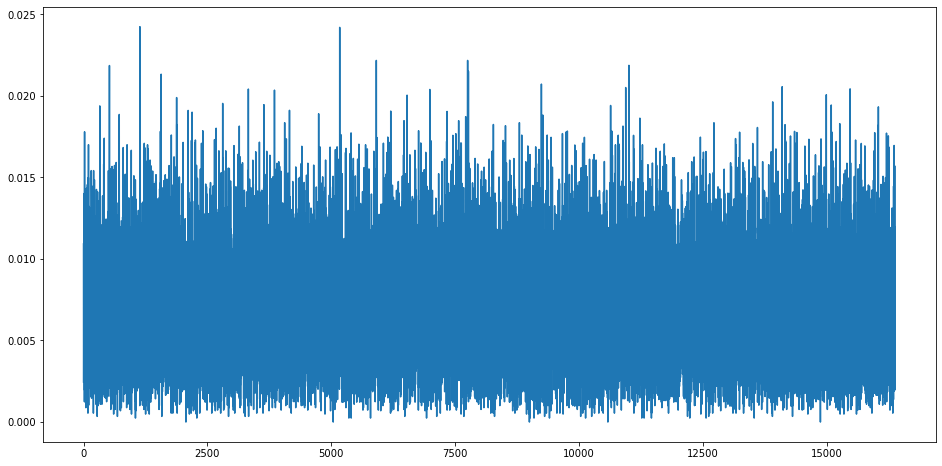

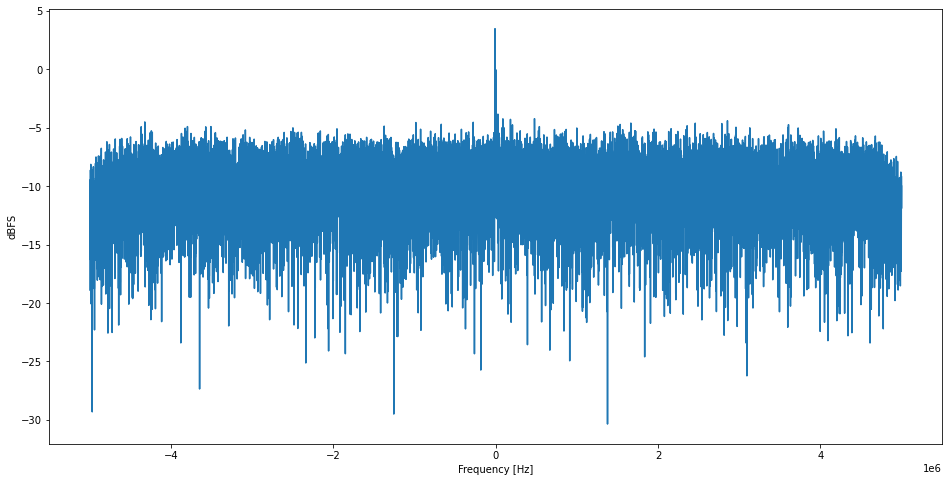

In [7]:
ds = nc.Dataset(nc_file)

i_data = ds.variables['i']
q_data = ds.variables['q']
units = i_data.units

# Take data from 1 time sample and create complex variable
iq_all = i_data[:] + 1j * q_data[:]
iq = iq_all[0,]
z_all = np.abs(iq_all)
z = np.abs(iq)

# Plot time series
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)

plt.plot(z / adc_size)

# Compute DFT and plot
X_k = fft.fft(iq) / (2 * buffer_size)
X_k = fft.fftshift(X_k)
X_k_dBFS = 10 * np.log10(X_k)
freq = np.linspace(-sample_rate / 2, sample_rate / 2, buffer_size)

fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Frequency [Hz]")
plt.ylabel("dBFS")

plt.plot(freq, X_k_dBFS)

***
## Noise calculation
### For coherent detectors, noise power can be estimated from the variance, $\sigma^2$,  (square of standard deviation)
$ \begin {align}
P_n &= \frac{\sigma^2}{2}
\end {align} $
<h2 style="color:red">INCOMPLETE</h2>

28.09162712097168
Mean: 28.09
Standard deviation: 14.63
Variance: 213.99
Noise power: 	107.00 bits
		-31.66 dBFS


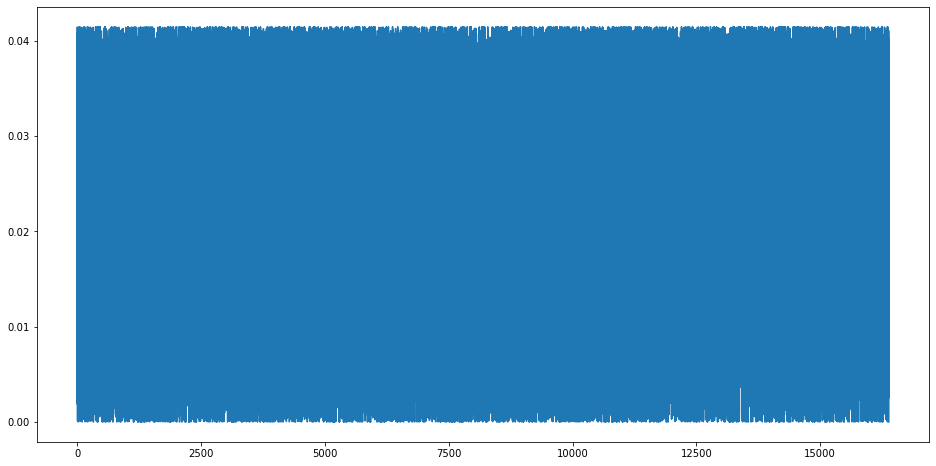

In [6]:
# Takes magnitude then caccalates standard deviation
z = np.abs(iq)
mean = np.mean(z)
print(mean)
std = np.std(z)
variance = std**2
print("Mean: %0.2f\nStandard deviation: %0.2f\nVariance: %0.2f" 
    % (mean, std, variance))

noise_power = variance / 2
noise_dBFS = 20 * np.log10(noise_power / adc_size)

print("Noise power: \t%0.2f bits\n\t\t%0.2f dBFS" %(noise_power, noise_dBFS))

pdf = (z / variance) * np.exp(-1 * z**2 / (2 * variance))
fig = plt.figure()
plt.plot(pdf)
fig.set_figwidth(16)
fig.set_figheight(8)

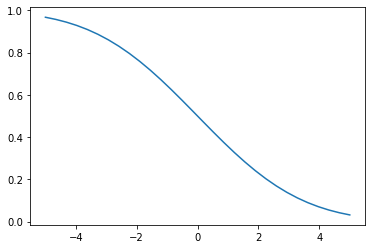

In [7]:
# Probability of false alarm
V = np.linspace(-5, 5, 30)
P_fa = 0.5 * (1 - scipy.special.erf(V / std**(0.5)))
plt.plot(V, P_fa)

In [19]:
np.sum(np.where(np.abs(iq) > adc_size))

0

***
## False alarm
### A false alarm occurs when noise jumps beyond the noise floor to a level similar to that of targets. There exists a voltage threshold, $V_T$, between a target and noise that is determined using SNR and determines the probability of false alarms, $P_{fa}$. 
$ \begin {align}
V_T &= \sqrt{-2\sigma^2 ln(P_{fa})} \\
P_d &= Q\left[\sqrt{2SNR}\sqrt{-2ln(P_{fa})}\right] \\
Q &- \text{Marcum's Q functions}
\end {align} $

***
## CFAR - Constant False Alarm Rate
### Since an incoming signal is constantly changing, the threshold, $V_T$, must also constantly update to classify parts of the signal as targets with the same false alarm rate.
### Common techniques:
#### **Cell averaging** - The mean power is taken of all the cells surrounding the cell under test (CUT), by the following equation:
$ \begin {align}
Z &= \frac{1}{N}\sum_{n=1}^{N}X_n \\ 
N &- \text{number of range cells being averaged} \\
X_n &- \text{signal power of } n^{th} \text{cell} \\
Z &- \text{local noise power estimate}
\end {align} $
#### **Greatest** - This is the same as the cell averaging technique but it only uses the nearby cells on the side of the CUT that have the larger mean.
#### **Smallest** - Very similar to the greatest technique but it takes the nearby cells with the smaller of the two means. 

#### To reduce interference from the CUT, nearby cells are omitted from the mean power and are called *guard cells*. 

#### To determine if a cell will be considered a target, the cell's value, $X$, must be greater than the average of the nearby cells multiplied by a bias factor, $C$. In other words, $X \ge CZ$ for a cell to be classified as a target.

C:\Users\banan\AppData\Local\Temp/ipykernel_47088/4067741268.py:61: RuntimeWarning: divide by zero encountered in log10
  ax.plot(freq, 10 * np.log10(cfar_values), color='r', linestyle='dashed', label='CFAR Values')


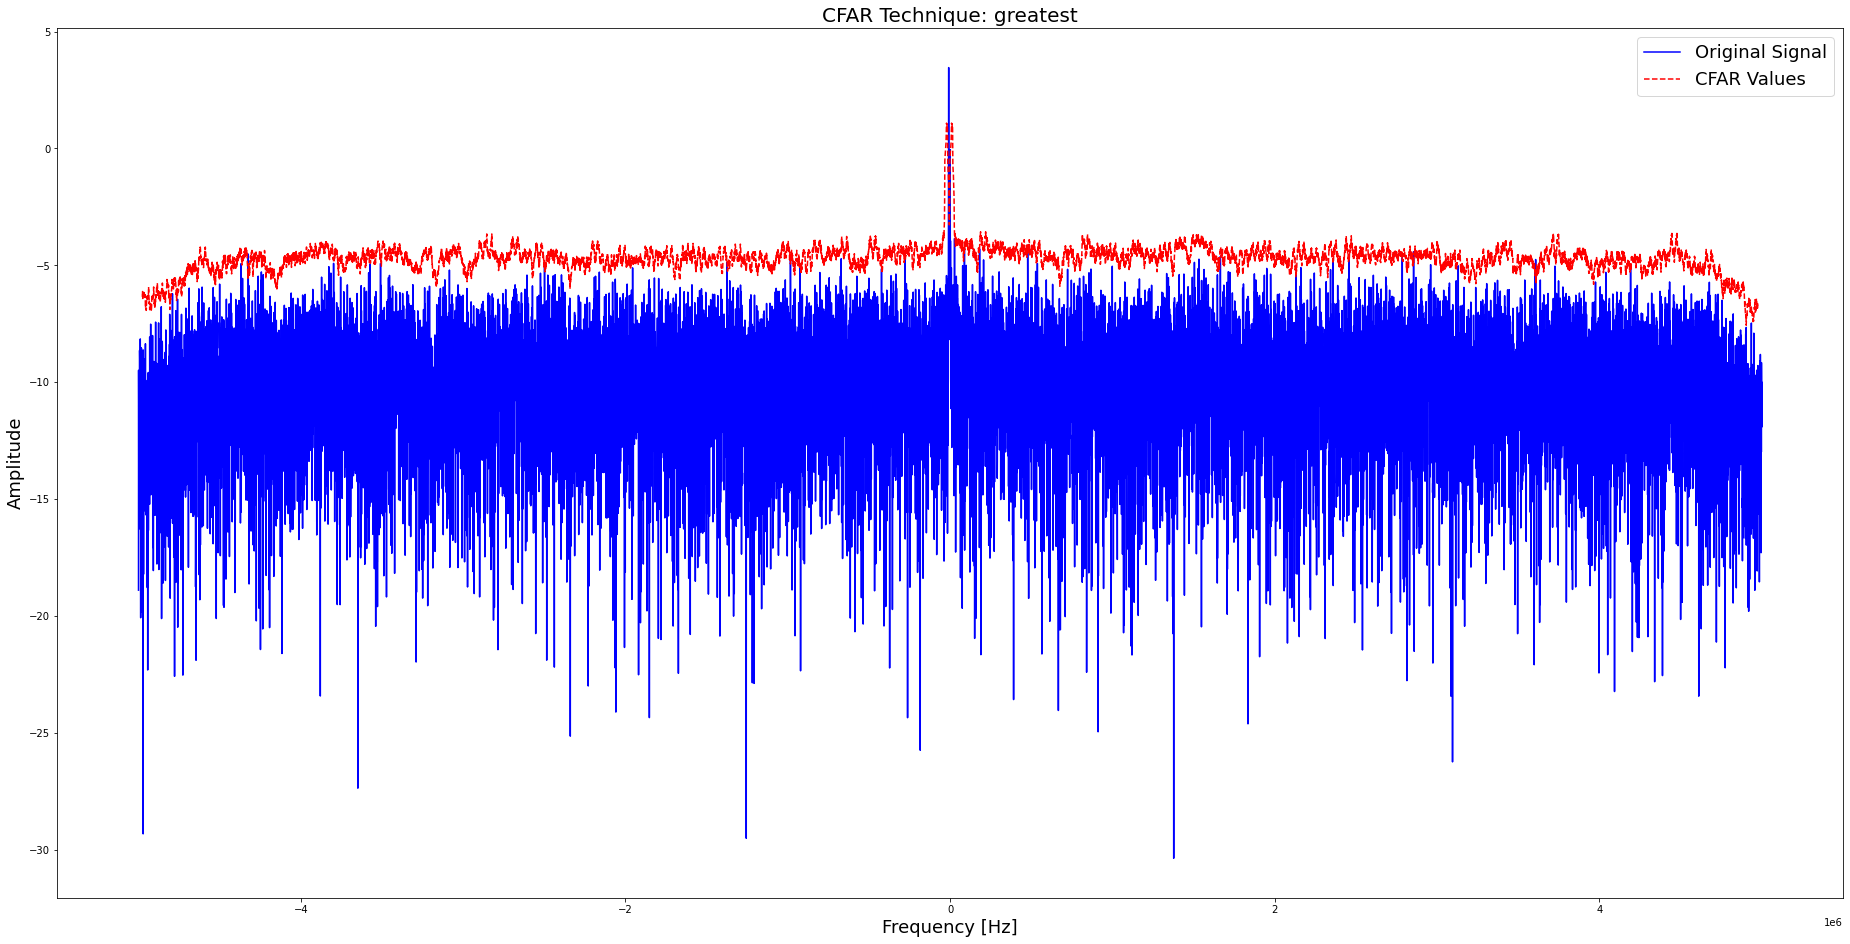

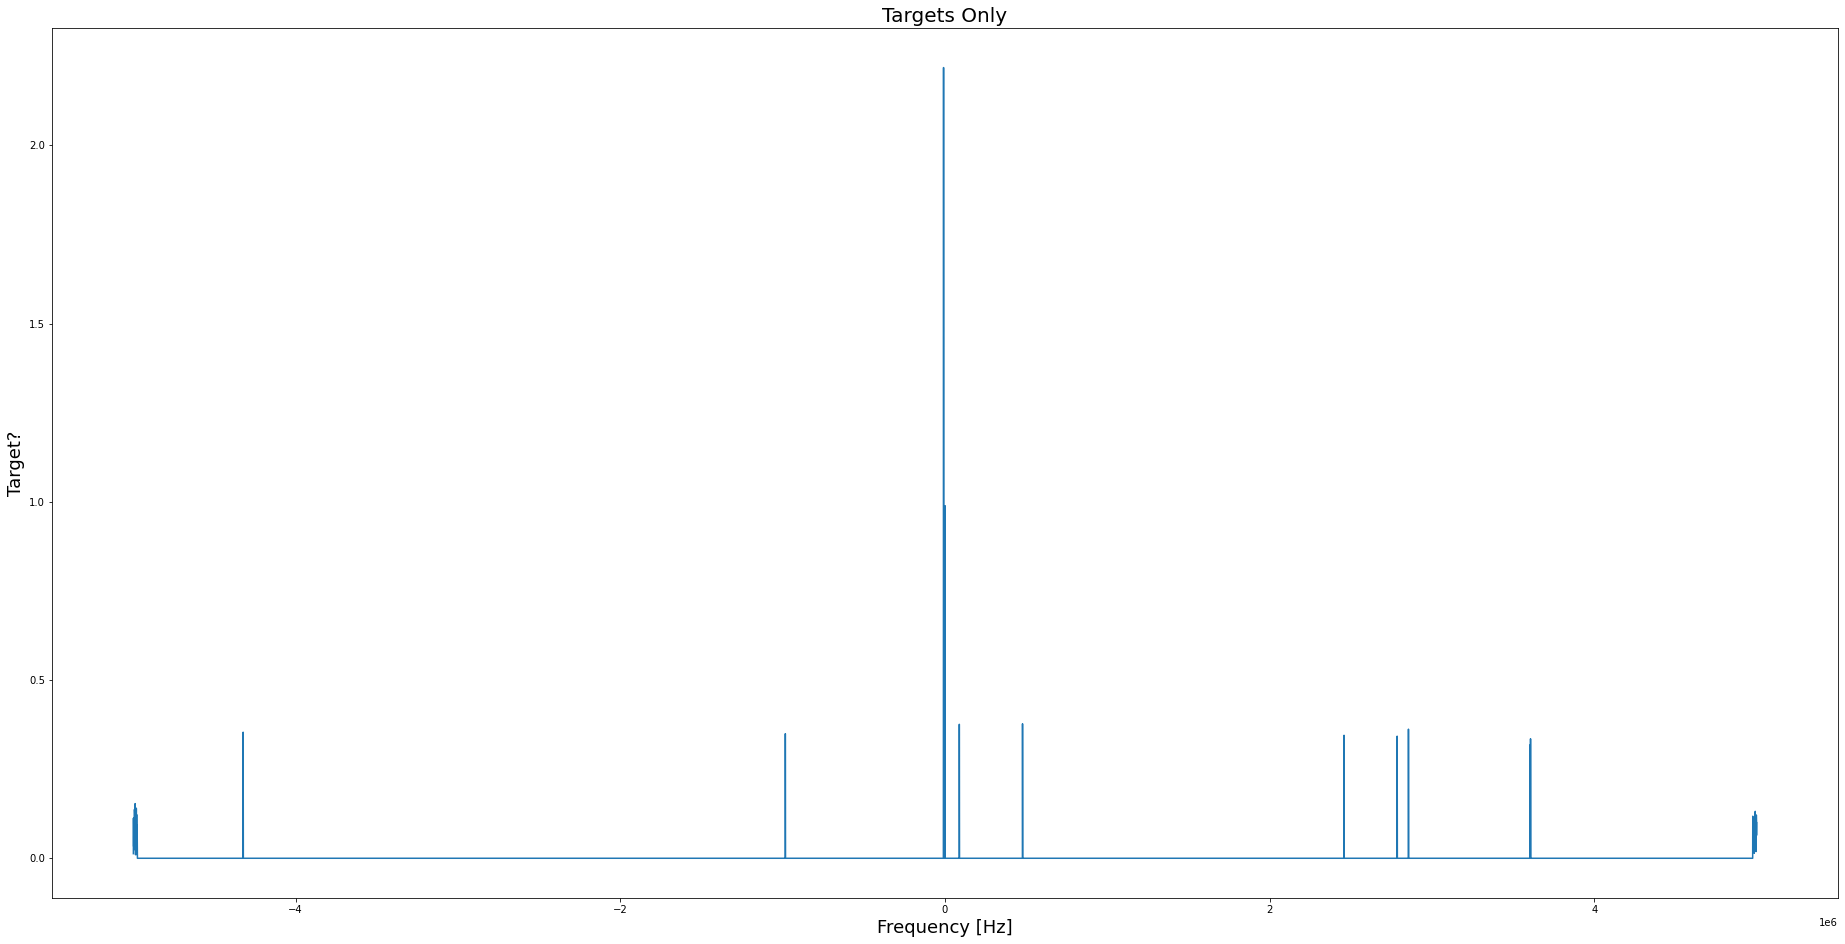

In [75]:
# Original signal
data = np.abs(X_k)

"""
    Options:
        'average'
        'greatest'
        'smallest'
"""
cfar_method = 'average'
cfar_method = 'greatest'
# cfar_method = 'smallest'

# Cell averaging parameters
num_guard_cells = 10
num_ref_cells = 30
bias = 3

N = X_k.size
cfar_values = np.zeros(X_k.shape)
for center_index in range(num_guard_cells + num_ref_cells, N - (num_guard_cells + num_ref_cells)):
    min_index = center_index - (num_guard_cells + num_ref_cells)
    min_guard = center_index - num_guard_cells 
    max_index = center_index + (num_guard_cells + num_ref_cells) + 1
    max_guard = center_index + num_guard_cells + 1

    lower_nearby = data[min_index:min_guard]
    upper_nearby = data[max_guard:max_index]

    lower_mean = np.mean(lower_nearby)
    upper_mean = np.mean(upper_nearby)

    if (cfar_method == 'average'):
        mean = np.mean(np.concatenate((lower_nearby, upper_nearby)))
    elif (cfar_method == 'greatest'):
        mean = max(lower_mean, upper_mean)
    elif (cfar_method == 'smallest'):
        mean = min(lower_mean, upper_mean)
    else:
        mean = 0

    output = mean * bias
    cfar_values[center_index] = output

targets_only = np.copy(data)
targets_only[np.where(data < cfar_values)] = np.ma.masked

"""
    Plotting
"""
# Plot CFAR values and original signal
fig, ax = plt.subplots()
ax.set_title("CFAR Technique: %s" % cfar_method, fontsize=20)
ax.set_xlabel("Frequency [Hz]", fontsize=18)
ax.set_ylabel("Amplitude", fontsize=18)
# fig.legend(['Original Signal', 'CFAR Values'], loc='upper right', fontsize=12)
fig.set_figheight(16)
fig.set_figwidth(32)

ax.plot(freq, 10 * np.log10(data), color='b', label="Original Signal")
ax.plot(freq, 10 * np.log10(cfar_values), color='r', linestyle='dashed', label='CFAR Values')
ax.legend(fontsize=18)

# Plot targets only
fig, ax = plt.subplots()
ax.set_title("Targets Only", fontsize=20)
ax.set_xlabel("Frequency [Hz]", fontsize=18)
ax.set_ylabel("Target?", fontsize=18)
fig.set_figheight(16)
fig.set_figwidth(32)

plt.plot(freq, targets_only)